In [1]:
import orcapod as op
import shutil

We will also make heavy use of PyArrow:

In [2]:
import pyarrow as pa

### Preparing the environment

In this notebook, we will create a local directory called `pipeline_data` and store results in there. To make sure we get reproducibile results, we start by making sure that this directory does not exist locally.

In [3]:
shutil.rmtree("./pipeline_data", ignore_errors=True)

### Creating streams

At the moment, there is only one way to create stream and that is by wrapping a PyArrow table.

In [4]:
table = pa.Table.from_pydict(
    {
        "a": [1, 2, 3],
        "b": ["x", "y", "z"],
        "c": [True, False, True],
        "d": [1.1, 2.2, 3.3],
    }
)

Use `op.streams.TableStream` to turn table into a stream. You will also have to specify which columns are the tags.

In [5]:
stream = op.streams.TableStream(table, tag_columns=["a", "b"])

In [6]:
stream = op.sources.DataFrameSource(table, tag_columns=["a", "b"])

### Working with streams

Once you have a stream, you can iterate through tag, packet pair:

In [7]:
for tag, packet in stream:
    print(f"Tag: {tag}, Packet: {packet}")

Tag: {'a': 1, 'b': 'x'}, Packet: {'c': True, 'd': 1.1}
Tag: {'a': 2, 'b': 'y'}, Packet: {'c': False, 'd': 2.2}
Tag: {'a': 3, 'b': 'z'}, Packet: {'c': True, 'd': 3.3}


You can also get all tag packet pairs as a list of tuples by calling `.flow()`

In [8]:
stream.flow()

[({'a': 1, 'b': 'x'}, {'c': True, 'd': 1.1}),
 ({'a': 2, 'b': 'y'}, {'c': False, 'd': 2.2}),
 ({'a': 3, 'b': 'z'}, {'c': True, 'd': 3.3})]

In [9]:
stream

*a,*b,c,d
i64,str,bool,f64
1,"""x""",true,1.1
2,"""y""",false,2.2
3,"""z""",true,3.3


In [10]:
stream.as_df()

a,b,c,d
i64,str,bool,f64
1,"""x""",true,1.1
2,"""y""",false,2.2
3,"""z""",true,3.3


Optionally, you can pass in arguments to `as_df` to have system columns included in the table

`include_source` adds `source` column for each data (non-tag) column patterned like `_source_{column}` and will contain information about where that particular value orginated from.

In [11]:
stream.as_df(include_source=True)

a,b,c,d,_source_c,_source_d
i64,str,bool,f64,str,str
1,"""x""",true,1.1,"""data_frame:source_5a4c41dbd055…","""data_frame:source_5a4c41dbd055…"
2,"""y""",false,2.2,"""data_frame:source_5a4c41dbd055…","""data_frame:source_5a4c41dbd055…"
3,"""z""",true,3.3,"""data_frame:source_5a4c41dbd055…","""data_frame:source_5a4c41dbd055…"


`include_content_hash` will compute `content_hash` for each packet and include it as `_content_hash` column

In [12]:
stream.as_df(include_content_hash=True)

a,b,c,d,_content_hash
i64,str,bool,f64,str
1,"""x""",true,1.1,"""arrow_v0.1:dbd5a1efe0a1a306cc2…"
2,"""y""",false,2.2,"""arrow_v0.1:083f8c4d8a4c7608af3…"
3,"""z""",true,3.3,"""arrow_v0.1:d4a11ad88c1d27eba1c…"


Alternatively, you can pass in a custom column name to use for the content hash column

In [13]:
stream.as_df(include_content_hash="my_hash_values")

a,b,c,d,my_hash_values
i64,str,bool,f64,str
1,"""x""",true,1.1,"""arrow_v0.1:dbd5a1efe0a1a306cc2…"
2,"""y""",false,2.2,"""arrow_v0.1:083f8c4d8a4c7608af3…"
3,"""z""",true,3.3,"""arrow_v0.1:d4a11ad88c1d27eba1c…"


Finally, `include_data_context` adds data context column as `_context_key` which captures information about the OrcaPod version, hasher version etc that were used when generting that packet.

In [14]:
stream.as_df(include_data_context=True)

a,b,c,d,_context_key
i64,str,bool,f64,str
1,"""x""",true,1.1,"""std:v0.1:default"""
2,"""y""",false,2.2,"""std:v0.1:default"""
3,"""z""",true,3.3,"""std:v0.1:default"""


If preferred you can view any stream as Arrow table by calling `as_table` method. It takes the same set of arguments as `as_df`

In [15]:
stream.as_table(include_data_context=True)

pyarrow.Table
a: int64
b: large_string
c: bool
d: double
_context_key: large_string
----
a: [[1,2,3]]
b: [["x","y","z"]]
c: [[true,false,true]]
d: [[1.1,2.2,3.3]]
_context_key: [["std:v0.1:default","std:v0.1:default","std:v0.1:default"]]

### Tags and Packets

The tags and packets returned by the streams can be thought of as special dictionary.

Let's work again with the stream we created earlier with the following content

In [16]:
stream

*a,*b,c,d
i64,str,bool,f64
1,"""x""",true,1.1
2,"""y""",false,2.2
3,"""z""",true,3.3


In [17]:
all_tags_and_packets = stream.flow()

In [18]:
tag, packet = all_tags_and_packets[0]

In [19]:
tag

{'a': 1, 'b': 'x'}

In [20]:
packet

{'c': True, 'd': 1.1}

The element of tag/packet can be accessed just like dictionary:

In [21]:
tag["a"]

1

In [22]:
tag["b"]

'x'

In [23]:
packet["c"]

True

In [24]:
packet["d"]

1.1

They have a few methods that will provide additional insights:

In [25]:
# Returns typespec (dictionary of key to type)
packet.types()

{'c': bool, 'd': float}

In [26]:
# entry names as strings
packet.keys()

('c', 'd')

They can also be converted to an Arrow table by calling `as_table`

In [27]:
packet.as_table()

pyarrow.Table
c: bool
d: double
----
c: [[true]]
d: [[1.1]]

In [28]:
packet.as_dict()

{'c': True, 'd': 1.1}

And schema is conveniently available as:

In [29]:
packet.arrow_schema()

c: bool
d: double

You can also get a plain dictionary from tag/packet with `as_dict`

In [30]:
tag.as_dict()

{'a': 1, 'b': 'x'}

Packet contains some additional data such as `source_info`

In [31]:
packet.source_info()

{'c': 'data_frame:source_5a4c41dbd0552e031d5a::row_0::c',
 'd': 'data_frame:source_5a4c41dbd0552e031d5a::row_0::c::d'}

These additional data can be included when converting to dict or table

In [32]:
packet.as_dict(include_source=True)

{'c': True,
 'd': 1.1,
 '_source_c': 'data_frame:source_5a4c41dbd0552e031d5a::row_0::c',
 '_source_d': 'data_frame:source_5a4c41dbd0552e031d5a::row_0::c::d'}

In [33]:
packet.as_table(include_source=True)

pyarrow.Table
c: bool
d: double
_source_c: large_string
_source_d: large_string
----
c: [[true]]
d: [[1.1]]
_source_c: [["data_frame:source_5a4c41dbd0552e031d5a::row_0::c"]]
_source_d: [["data_frame:source_5a4c41dbd0552e031d5a::row_0::c::d"]]

The hash of tag/packet can be computed with `content_hash()` method. The result will be cached so that it won't be computed again unnecessarily.

In [34]:
tag.content_hash()

ContentHash(method='arrow_v0.1', digest=b'n\x11C\x89ms\xd3pux\x11\xb5,\xee\xea\x8d\x1dEl\xd3\x02\x06Ao\xbf\x81uN\x1c\xeaUh')

## Working with operators

We start getting into orcapod computation when we use operators. At the time of the writing, only `Join` operator is implemented fully but more are to come very shortly.

Let's prepare two streams:

In [35]:
table1 = pa.Table.from_pydict(
    {
        "id": [0, 1, 4],
        "a": [1, 2, 3],
        "b": ["x", "y", "z"],
    }
)

table2 = pa.Table.from_pydict(
    {
        "id": [0, 1, 2],
        "c": [True, False, True],
        "d": [1.1, 2.2, 3.3],
    }
)

stream1 = op.streams.TableStream(table1, tag_columns=["id"])
stream2 = op.streams.TableStream(table2, tag_columns=["id"])

In [36]:
stream1

*id,a,b
i64,i64,str
0,1,"""x"""
1,2,"""y"""
4,3,"""z"""


In [37]:
stream2

*id,c,d
i64,bool,f64
0,true,1.1
1,false,2.2
2,true,3.3


We now join the two streams by instantiating the Join operator and then passing in the two streams:

In [38]:
join = op.operators.Join()

In [39]:
joined_stream = join(stream1, stream2)

Calling an operator on stream(s) immediately performs checks to make sure that the input streams are comaptible with the operator but otherwise it does NOT trigger any computation. Computation occurs only when you try to **access the output stream's content via iteration, flow, or through conversion to table**.

The output of the computation is automatically cached so that as long as you access the same output stream, you won't be triggering unnecessary recomputation!

In [40]:
joined_stream

*id,a,b,c,d
i64,i64,str,bool,f64
0,1,"""x""",true,1.1
1,2,"""y""",false,2.2


### [NEW] Convenience methods

In fact, streams comes with methods to conveniently perform common operators

In [41]:
stream1.join(stream2)

*id,a,b,c,d
i64,i64,str,bool,f64
0,1,"""x""",true,1.1
1,2,"""y""",false,2.2


In [42]:
stream1.semi_join(stream2)

*id,a,b
i64,i64,str
0,1,"""x"""
1,2,"""y"""


In [43]:
stream1.map_packets({"a": "a_mapped"})

*id,a_mapped
i64,i64
0,1
1,2
4,3


In [44]:
stream1.map_tags({"id": "name"})

*name,a,b
i64,i64,str
0,1,"""x"""
1,2,"""y"""
4,3,"""z"""


## Working with Function Pods

Now we have explored the basics of streams, tags, packets, and operators (i.e. Join), it's time to explore the meat of `orcapod` -- `FunctionPod`s! Let's start by defining a very simple function pod that takes in two numbers and return the sum.

In [45]:
@op.function_pod("sum")
def add_numbers(a: int, b: int) -> int:
    """A simple function pod that adds two numbers."""
    return a + b

In [46]:
add_numbers(5, 10)

15

In [47]:
add_numbers.pod

FunctionPod:add_numbers

You'll notice that, aside from the `op.function_pod` decorator, this is nothing but an ordinary Python function with type hints! The type hints are crucial however, as this will be used by `orcapod` system to validate the input streams into your pods and to be able to predict if the output of your pod can be fed into another operator/pod without an issue.

Once you have function pod defined, you can already use it on streams just like operators. Let's prepare a stream that has entries for `a` and `b` and then feed them into the function pod.

In [48]:
input_table = pa.Table.from_pydict(
    {
        "id": [0, 1, 2, 3, 4],
        "a": [1, 2, 3, 4, 5],
        "b": [10, 20, 30, 40, 50],
    }
)

input_stream = op.sources.ArrowTableSource(input_table, tag_columns=["id"])

In [49]:
input_stream

*id,a,b
i64,i64,i64
0,1,10
1,2,20
2,3,30
3,4,40
4,5,50


In [50]:
# run the stream through the function pod!
output_stream = add_numbers.pod(input_stream)

And that's it! Believe it or not, that is all it takes to set up the computation. The actual computation will be triggered the first time you access the content of the output stream.

In [51]:
output_stream

*id,sum
i64,i64
0,11
1,22
2,33
3,44
4,55


If you prefer, you can explicitly trigger the comptuation by calling `run` method. In a future tutorial, we will see how we can combine `run` with execution engine to achieve asynchronous computations!

In [52]:
output_stream.run()

### [NEW] Pods with structured inputs and outputs

You can now use more complex structured data types like lists and dictionaries in your input and output for a pod

In [53]:
@op.function_pod(output_keys=["stats"])
def compute_stats(a: int, b: int) -> dict[str, int]:
    """Compute various statistics."""
    return {"sum": a + b, "difference": a - b, "product": a * b}


@op.function_pod(output_keys=["message"])
def build_message(stats: dict[str, int]) -> str:
    """Build a message from the stats."""
    return f"Hi! The sum was {stats['sum']}, the difference was {stats['difference']}, and the product was {stats['product']}."

In [54]:
input_stream

*id,a,b
i64,i64,i64
0,1,10
1,2,20
2,3,30
3,4,40
4,5,50


In [55]:
stats_output = compute_stats.pod(input_stream)
messages = build_message.pod(stats_output)

In [56]:
stats_output

*id,stats
i64,list[struct[2]]
0,"[{""sum"",11}, {""difference"",-9}, {""product"",10}]"
1,"[{""sum"",22}, {""difference"",-18}, {""product"",40}]"
2,"[{""sum"",33}, {""difference"",-27}, {""product"",90}]"
3,"[{""sum"",44}, {""difference"",-36}, {""product"",160}]"
4,"[{""sum"",55}, {""difference"",-45}, {""product"",250}]"


In [57]:
messages

*id,message
i64,str
0,"""Hi! The sum was 11, the differ…"
1,"""Hi! The sum was 22, the differ…"
2,"""Hi! The sum was 33, the differ…"
3,"""Hi! The sum was 44, the differ…"
4,"""Hi! The sum was 55, the differ…"


## Chaining operators and pods into a pipeline

Now that we have seen how to define and run pods, it's time to put them together into a concrete pipeline. To do so, we will construct a `Pipeline` instance. When doing so, we have to pass in a place to save data to, so we will also prepare a data store.

In [58]:
database = op.databases.DeltaTableDatabase(base_path="./pipeline_data")

pipeline = op.Pipeline(name="my_pipeline", pipeline_database=database)

Once we have the pipeline ready, we can define the pipeline by simply running & chaining operators and pods **inside the pipeline context**. Typically, you'd want to define your function pods before hand:

In [59]:
@op.function_pod(output_keys=["sum"])
def add_numbers(a: int, b: int) -> int:
    """A simple function pod that adds two numbers."""
    return a + b


@op.function_pod(output_keys=["product"])
def multiply_numbers(a: int, b: int) -> int:
    """A simple function pod that multiplies two numbers."""
    return a * b


@op.function_pod(output_keys=["result"])
def combine_results(sum: int, product: int) -> str:
    """A simple function pod that combines results."""
    return f"Sum: {sum}, Product: {product}"

In [60]:
# now defien the pipeline
with pipeline:
    sum_results = add_numbers.pod(input_stream)
    product_results = multiply_numbers.pod(input_stream)
    final_results = combine_results.pod(sum_results, product_results)

In [61]:
input_stream

*id,a,b
i64,i64,i64
0,1,10
1,2,20
2,3,30
3,4,40
4,5,50


In [62]:
pipeline.add_numbers

*id,_tag::source:57778e89cbc0,sum,_source_sum,_context_key
i64,str,i64,str,str


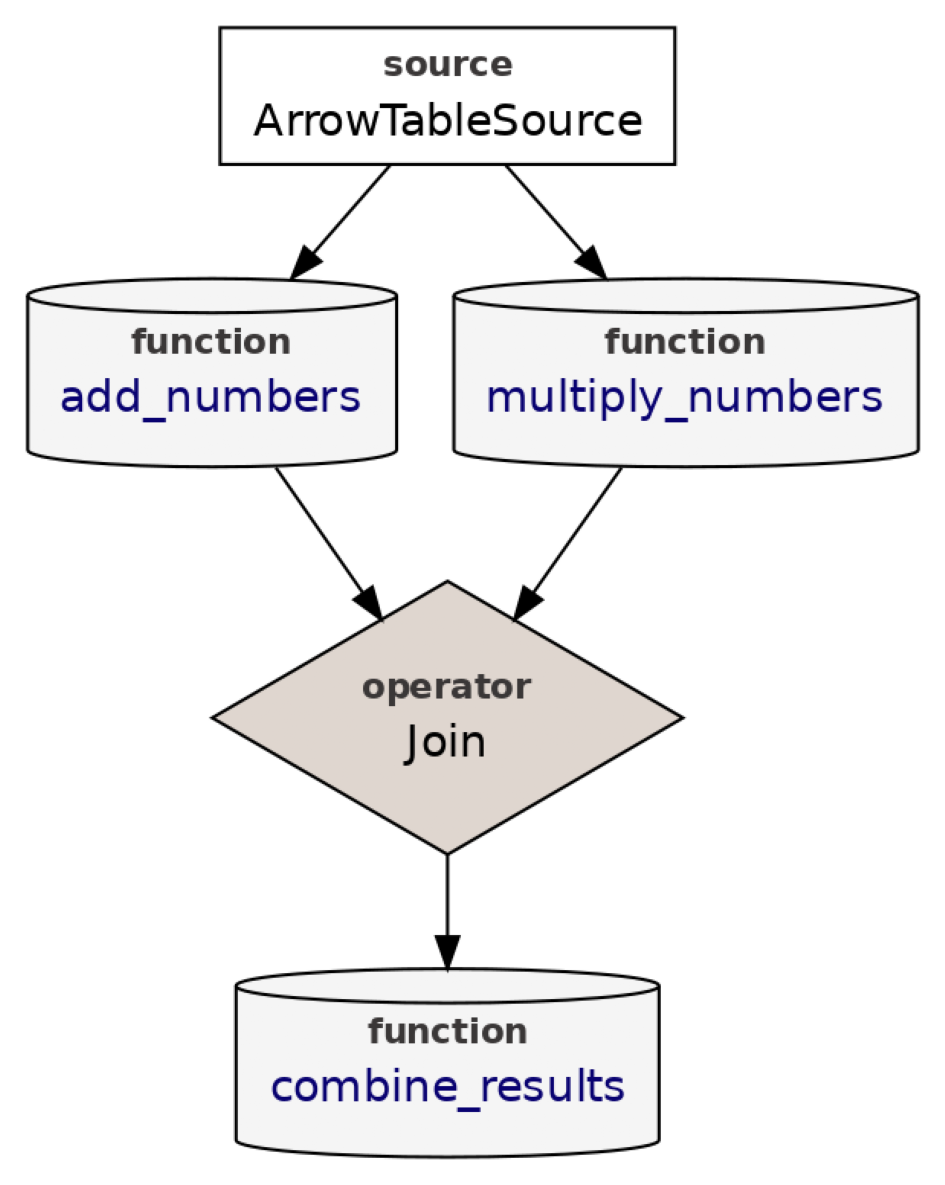

In [63]:
pipeline.show_graph()

You can access individual elements of the pipeline as an attribute. By default, the attribute is named after the operator/pod name.

In [64]:
pipeline.multiply_numbers

*id,_tag::source:57778e89cbc0,product,_source_product,_context_key
i64,str,i64,str,str


In [65]:
pipeline.Join

*id,sum,product,_context_key_right
i64,i64,i64,str


In [66]:
pipeline.nodes

{'ArrowTableSource': KernelNode(kernel=ArrowTableSource),
 'add_numbers': PodNode(pod=FunctionPod:add_numbers),
 'multiply_numbers': PodNode(pod=FunctionPod:multiply_numbers),
 'Join': KernelNode(kernel=Join()),
 'combine_results': PodNode(pod=FunctionPod:combine_results)}

Notice that elements of the pipeline is wrapped in a `Node`, being either `PodNode` or `KernelNode`.

You can fetch results of the pipeline through these nodes. For example, you can access the saved results of the pipeline as Polars dataframe by access the `df` attribute.

You'll notice that `df` comes back empty because the pipeline is yet to run. Let's now trigger the pipeline to fill the nodes with computation results!

In [67]:
pipeline.run()

This will cause all nodes in the pipeline to run and store the results.

Now let's take a look at the computed results:

In [68]:
pipeline.add_numbers

*id,sum
i64,i64
0,11
1,22
2,33
3,44
4,55


In [69]:
pipeline.Join

*id,sum,product
i64,i64,i64
0,11,10
1,22,40
2,33,90
3,44,160
4,55,250


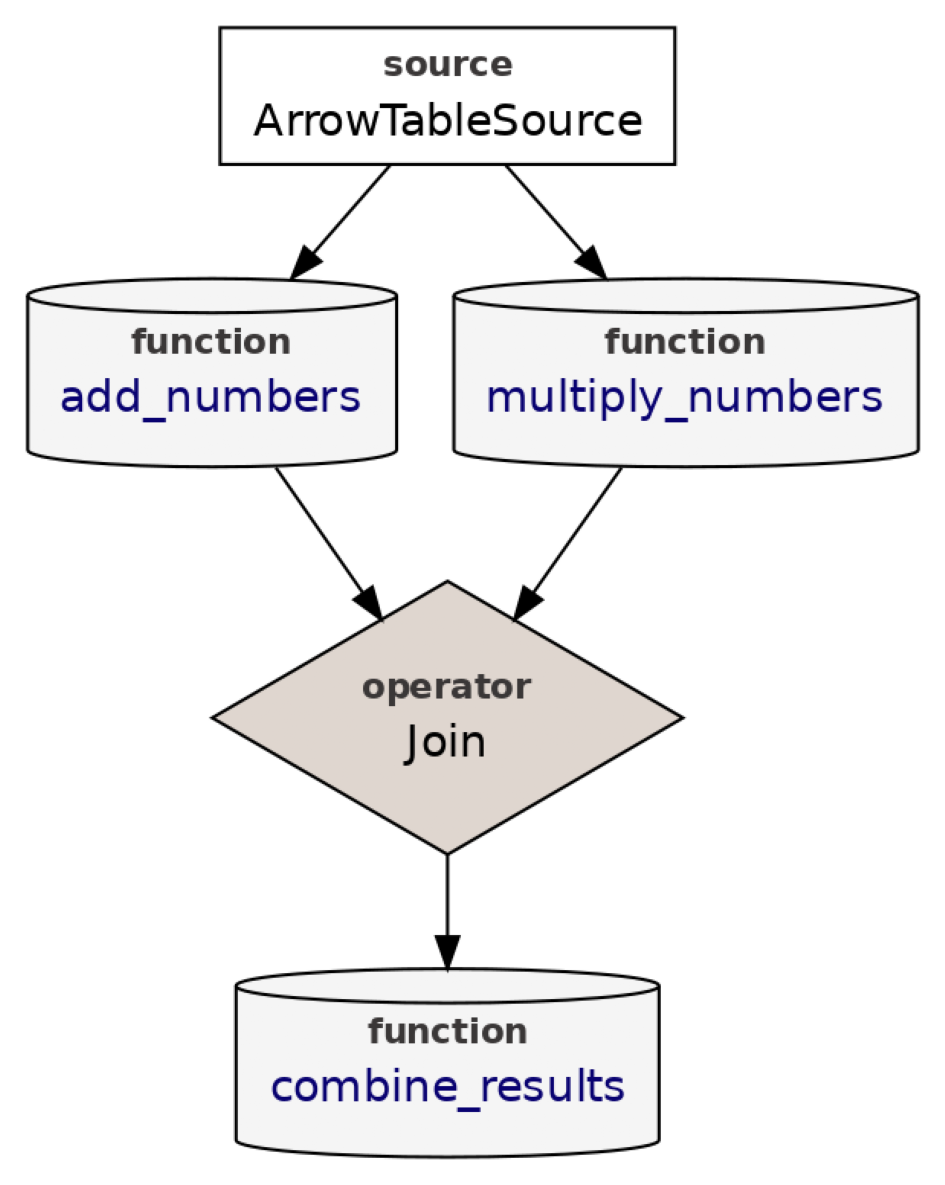

In [70]:
pipeline.show_graph()

You now have the computations saved at each node!

### Labeling nodes in the pipeline

When constructing the pipeline, each invocation of the operator/pod results in a new node getting added, with the name of the node defaulting to the name of the operator/pod. If you use the same pod multiple times, then the nodes will be given names of form `{pod_name}_0`, `{pod_name}_1`, and so on.

While this is helpful default behavior, you'd likely want to explicitly name each node so you can more easily understand what you are accessing within the pipeline. To achieve this, you can explicitly label each invocation with `label=` argument in the call.

In [71]:
database = op.databases.DeltaTableDatabase(base_path="./pipeline_data")

pipeline2 = op.Pipeline(name="my_pipeline", pipeline_database=database)

In [72]:
# now defien the pipeline
with pipeline2:
    sum_results = add_numbers.pod(input_stream, label="my_summation")
    product_results = multiply_numbers.pod(input_stream, label="my_product")
    final_results = combine_results.pod(
        sum_results, product_results, label="my_final_result"
    )

In [73]:
pipeline2.my_summation

*id,sum
i64,i64
0,11
1,22
2,33
3,44
4,55


In [74]:
pipeline2.my_product

*id,product
i64,i64
0,10
1,40
2,90
3,160
4,250


In [75]:
pipeline2.my_final_result

*id,result
i64,str
0,"""Sum: 11, Product: 10"""
1,"""Sum: 22, Product: 40"""
2,"""Sum: 33, Product: 90"""
3,"""Sum: 44, Product: 160"""
4,"""Sum: 55, Product: 250"""


Notice that despite just freshly creating the pipeline, each node already had results filled in! This is because the results from the previous pipeline with the same name (`my_pipeline`) was smartly fetched back. Critically, this was done only because Orcapod noticed that you had an identical pipeline with the same inputs and same operators/pods so that you can reuse the result as is. Should the structure of pipeline been different, the wront results would not be loaded.